# Predcition modeling

- 주어진 데이터들의 feature를 가지고 환자들의 진료 이탈 여부 예측
- 사용할 Features
    * 성별
    * 연령
    * Scholarship(소득지원 여부)
    * 고혈압 여부
    * 당뇨병 여부
    * 알코올중독 여부
    * 장애 여부
    * SMS 푸쉬알림 수신 여부
    * date_diff(예약을 등록한날과 예약 방문날 사이의 시간 차이)

## 배경

- 'A'라는 병원과 제휴를 맺은 IT 솔루션 기반 헬스케어 기업은 A병원으로부터 환자들의 높은 진료 이탈율의 원인이 무엇인지 데이터를 통해 인사이트 도출 요청

## 목적 

- 주어진 환자들의 여러가지 개인적인 특성 데이터를 기반으로 향후 진료 이탈 여부를 예측
- 이를 통해 잠재적인 진료 이탈 고객을 분류하고 진료 이탈을 막기위해 향후 전략 수립

## 가설

- 이전에 실시한 데이터 분석결과에 따르면 date_diff 변수가 진료 이탈 여부에 영향이 가장 큰 변수일 것으로 예상

In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data')

In [2]:
medical = pd.read_csv('medical_appointment_final.csv')
medical.shape

(106987, 15)

In [3]:
del medical['Unnamed: 0']

## 예측 모델링 프로세스

### 결측치 처리

In [4]:
medical.isnull().sum()

Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
date_diff         0
Age_range         0
dtype: int64

In [5]:
# feature들의 dtype을 보면서 "이건 무조건 numeric type이어야 하는데 object type이 있는지 확인"
medical.dtypes

Gender            object
ScheduledDay      object
AppointmentDay    object
Age                int64
Neighbourhood     object
Scholarship        int64
Hipertension       int64
Diabetes           int64
Alcoholism         int64
Handcap            int64
SMS_received       int64
No-show           object
date_diff          int64
Age_range         object
dtype: object

### 이상치 처리

In [6]:
# numeric 변수들만 따로 추출해 이상치 확인하기
numeric_cols = ['Age','date_diff']
numeric_df = medical[['Age','date_diff']]

In [7]:
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import cufflinks as cf
import warnings
warnings.filterwarnings(action='ignore')
cf.go_offline(connected=True)

numeric_df.iplot(kind='box')

In [8]:
# date_diff에 음수값들이 존재한다. 자세히 살펴보기
diff_outlier = medical.loc[medical['date_diff'] < 0]
print('date_diff값이 0미만인 데이터 개수: ',diff_outlier.shape[0])
diff_outlier

date_diff값이 0미만인 데이터 개수:  5


,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,date_diff,Age_range
26222,M,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,-1,20~30대
53324,F,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,-1,10대
62055,F,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,-1,20~30대
69225,F,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,-6,80대이상
70039,M,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes,-1,10대


- 진료를 등록하는 날 이전에 진료방문날이 있을 수가 없다. 아마도 이 데이터는 ScheduledDay와 AppointmentDay 값이 서로 바뀐듯 하다.
- 따라서 음수의 값을 양수의 값으로 바꾸어주자

In [9]:
def change_to_positive(row):
    if row['date_diff'] < 0:
        row['date_diff'] = abs(row['date_diff'])
    return row

In [10]:
test = medical.apply(change_to_positive, axis=1)
test['date_diff'].describe()

count    106987.000000
mean         10.166908
std          15.263383
min           0.000000
25%           0.000000
50%           4.000000
75%          14.000000
max         179.000000
Name: date_diff, dtype: float64

In [11]:
# 음수값을 양수값으로 수정한 데이터프레임을 다시 medical 원본 데이터프레임에 할당
medical = test

In [12]:
# date_diff값의 이상치를 판별하기 위해서 이상치 계산 함수 만들기
def check_outlier_date_diff(df):
    Q1 = df['date_diff'].quantile(0.25)
    Q3 = df['date_diff'].quantile(0.75)
    IQR = Q3 - Q1
    lowest = Q1 - 3*IQR
    highest = Q3 + 3*IQR
    
    outlier_idx = df.loc[(df['date_diff'] < lowest) | (df['date_diff'] > highest)].index
    outlier_df = df.iloc[outlier_idx]
    return outlier_df

In [13]:
# date_diff의 이상치 기준에 속하는 데이터 추출
outlier_df = check_outlier_date_diff(medical)
outlier_df.shape

(2403, 14)

In [14]:
print(outlier_df['date_diff'].min())
print(outlier_df['date_diff'].max())

57
179


- 이상치 데이터들 중에서 date_diff 값과 상이하게 비이상적으로 No-show label이 들어갔는지 여부를 확인해야 한다.

In [15]:
# date_diff 이상치 데이터들 중에서 No-show label값에 따라 데이터를 이중으로 분할하자
no_show_outlier = outlier_df[outlier_df['No-show']=='Yes'] # 향후 진료 안받음
show_outlier = outlier_df[outlier_df['No-show']=='No'] # 향후 진료 받음

<AxesSubplot:>

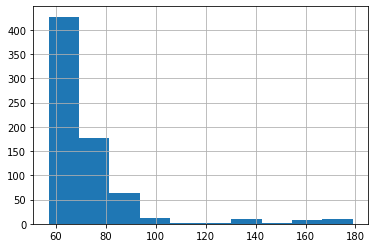

In [16]:
# 이상치라고 판단되는 데이터들 중에서 향후 진료를 받지 않은 데이터들의 date_diff 값 분포도
no_show_outlier['date_diff'].hist()

<AxesSubplot:>

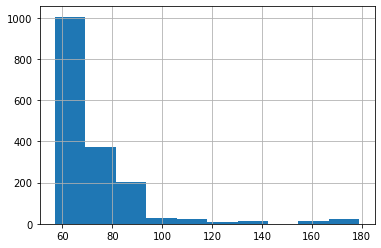

In [17]:
# 이상치라고 판단되는 데이터들 중에서 향후 진료를 받은 데이터들의 date_diff 값 분포도
show_outlier['date_diff'].hist()

- 이상치라고 판단되는 데이터들 중 향후 진료에 방문한 사람들의 date_diff 값 분포도와 향후 진료에 방문하지 않은 사람들의 date_diff 값 분포도가 동일하다.
- 이는 결국 비이상적으로 들어간 이상치는 없는 것으로 판단된다.

- age 변수는 범위상으로 이상치가 존재하긴 하지만 115살의 연령대는 충분히 존재할 가능성이 있기 때문에 제거하지 않는다.
    * 따라서 feature engineering 단계시, scaling이 필요할 듯 하다.
    
- date_diff 변수도 마찬가지로 이상치에 민감하지 않은 ``Robust scaling``이 적절할 듯 판단된다.

### 데이터 분포 변환

- 특정 분포를 따른다고 가정하는 모수적 추론 방법들 중 선형 모델의 경우, 독립,종속변수가 정규분포를 따른다고 가정한다. 따라서 정규분포화를 시켜주기 위한 단위 변환을 시도해준다.

<AxesSubplot:>

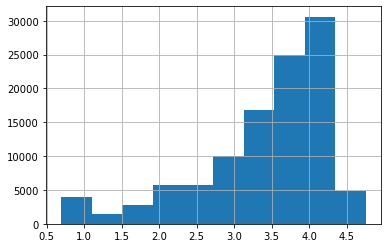

In [18]:
# numeric 변수인 Age, date_diff에 대한 분포도 확인 후 변환 적용 - log1p 적용
np.log1p(medical['Age']).hist()

<AxesSubplot:>

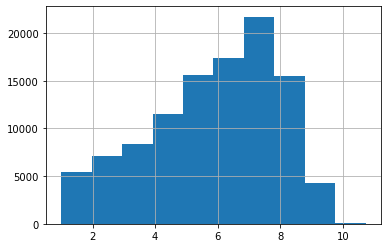

In [19]:
# numeric 변수인 Age, date_diff에 대한 분포도 확인 후 변환 적용 - 제곱근 적용
np.sqrt(medical['Age']).hist()

- Age에는 log보다 ``sqrt(제곱근)을 적용``해 정규분포에 매우 근사하게 변환할 수 있다.

<AxesSubplot:>

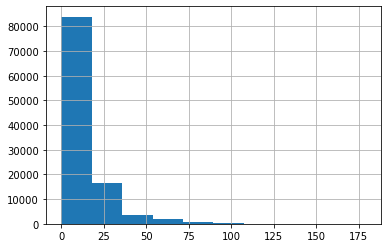

In [20]:
# date_diff 원래 분포형태
medical['date_diff'].hist()

- date_diff는 scaling을 적용해야 할 듯 하다

### 범주형 변수 인코딩

In [21]:
# 우선 필요없는 변수 삭제
no_cols = ['ScheduledDay','AppointmentDay','Neighbourhood','Age_range']
medical_df = medical.drop(no_cols, axis=1).copy()
medical_df.columns

Index(['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes',
       'Alcoholism', 'Handcap', 'SMS_received', 'No-show', 'date_diff'],
      dtype='object')

In [22]:
# 성별 원-핫 인코딩으로 만들어주기
one_hot_gender = pd.get_dummies(medical_df['Gender'], prefix='Gender')
medical_df = pd.concat([medical_df, one_hot_gender], axis=1)

In [23]:
del medical_df['Gender']

In [24]:
# Age변수 sqrt변환하기
medical_df['Age'] = np.sqrt(medical_df['Age'])

In [25]:
# Target variable encoding
show_dict = {'No':0, 'Yes':1}
medical_df['No-show'] = medical_df['No-show'].map(show_dict)

In [26]:
# 칼럼 순서 재배열
cols_lst = medical_df.columns.tolist()
cols_lst.remove('No-show')
# insert(인덱스위치, 값)
cols_lst.insert(10, 'No-show')
print(cols_lst)

['Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'date_diff', 'Gender_F', 'Gender_M', 'No-show']


In [27]:
final_data = medical_df[cols_lst]
final_data.head()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,date_diff,Gender_F,Gender_M,No-show
0,7.874008,0,1,0,0,0,0,0,1,0,0
1,7.483315,0,0,0,0,0,0,0,0,1,0
2,7.874008,0,0,0,0,0,0,0,1,0,0
3,2.828427,0,0,0,0,0,0,0,1,0,0
4,7.483315,0,1,1,0,0,0,0,1,0,0


## 모델링 구축 전 확인 사항

- 범주형, 연속형 데이터 형식의 적절성
- 이상치 및 결측치 처리 여부
- 스케일링 및 분포 변환
- 다중공선성 문제
    * 해결 위해 PCA와 같은 차원 축소, 변수 통합
    * 또는 Regularization 적용
- 예측변수(y)의 분포 imbalance 문제
- 변수 축소 및 파생 변수 생성

<AxesSubplot:>

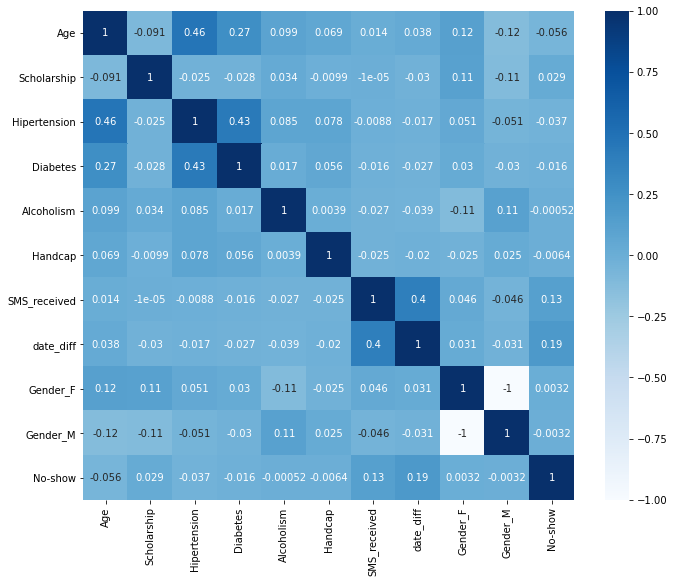

In [28]:
# 다중공산성 문제 확인
import seaborn as sns
corr = final_data.corr()
plt.figure(figsize=(11,9))
sns.heatmap(corr, cmap='Blues', annot=True)

- 다중공산성 확인 결과, 다음과 같은 3개 변수끼리 서로 상관관계가 존재
    * Hipertension - Age
    * Diabetes - Age
    * Diabetes - Hipertension

- 하지만 다중공산성은 linear regression에 기반한 모델에 부정적 효과
- Random Forest, Decision Tree같은 비모수적 추론 방법에는 다중공산성이 존재해도 영향 없음!

### Class imbalance

In [29]:
# 클래스 불균형 확인해보기
final_data['No-show'].value_counts()

0    85307
1    21680
Name: No-show, dtype: int64

- 해당 문제는 재현율이 정밀도 보다는 높아야하는 이진분류 문제이다. 재현율은 ``실제 label이 1인 데이터를 모델이 1로 예측해야 하는 비율이다``.
- 현재 문제 종류의 특성상, ``label=1이라는 것은 향후 진료에 참여하지 않는 환자들이고 이러한 환자들을 제대로 예측하는 것이 목표``이기 때문이다.
- 그렇다면 현재 ``label=1인 데이터 개수가 적으므로 종합적인 분류 정확도를 산출하면 높을 수 밖에 없다``.
- 따라서, ``label=1인 데이터 개수를 오버샘플링``해야 한다.

In [30]:
# final_data에서 독립변수, 종속변수 나누기
feature_df = final_data.iloc[:,:-1]
target_df = final_data.iloc[:,-1]

- 오버샘플링을 하기 전 데이터 분할부터 시도해야 한다.
- 우선 Train, Test로 데이터를 label분포에 맞게 분할하자.
- 그리고 Train 데이터에서 오버샘플링을 적용한 후 Train, Validation으로 다시 분할
- Test 데이터에 오버샘플링을 하지 않는 이유는 이 Test 데이터가 `실제 데이터`로 간주하기 때문이다. ``실제 데이터는 원본 데이터의 label 분포와 비슷하게 주어질 것이기 떄문이다.``

In [31]:
# Train, Test 데이터로 9 : 1 로 분할하기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature_df,
                                                   target_df,
                                                   test_size=0.1,
                                                   random_state=42)
print("Train Shape :", X_train.shape)
print("Train label 분포:\n", y_train.value_counts())
print('-'*30)
print("Test shape :", X_test.shape)
print("Test label 분포:\n", y_test.value_counts())

Train Shape : (96288, 10)
Train label 분포:
 0    76759
1    19529
Name: No-show, dtype: int64
------------------------------
Test shape : (10699, 10)
Test label 분포:
 0    8548
1    2151
Name: No-show, dtype: int64


In [32]:
# Train data에 KNN기반 오버샘플링 SMOTE 적용
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

print('오버샘플링 전 shape', X_train.shape, y_train.shape)
print('오버샘플링 전 label 분포\n', y_train.value_counts())
print('-'*30)
print('오버샘플링 후 shape', X_train_over.shape, y_train_over.shape)
print('오버샘플링 후 label 분포\n', y_train_over.value_counts())

오버샘플링 전 shape (96288, 10) (96288,)
오버샘플링 전 label 분포
 0    76759
1    19529
Name: No-show, dtype: int64
------------------------------
오버샘플링 후 shape (153518, 10) (153518,)
오버샘플링 후 label 분포
 1    76759
0    76759
Name: No-show, dtype: int64


**``X_train_over : Train+Validation 결합한 오버샘플링 데이터``**
- 이것은 향후 교차검증할 때 사용해야 함!

In [33]:
# 오버샘플링한 Train 데이터를 Train : Val = 9 : 1 로 분할하기
X_train, X_val, y_train, y_val = train_test_split(X_train_over,
                                                 y_train_over,
                                                 test_size=0.1,
                                                 random_state=43)
print('Train data shape:', X_train.shape)
print('Train label 분포:\n', y_train.value_counts())
print('-'*30)
print('Validation data shape:', X_val.shape)
print('Validation label 분포:\n', y_val.value_counts())

Train data shape: (138166, 10)
Train label 분포:
 0    69127
1    69039
Name: No-show, dtype: int64
------------------------------
Validation data shape: (15352, 10)
Validation label 분포:
 1    7720
0    7632
Name: No-show, dtype: int64


## 모델링

- PCA, Scaling은 모델 성능이 좋지 않을 시 적용

### Logistic Regression

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
# evaluate metric 함수 정의
def get_eval(y_test, y_pred, y_proba=None):
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    return acc, pre, rec, f1, matrix, auc

In [35]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_val)
y_proba = lr_clf.predict_proba(X_val)[:,1]
acc, pre, rec, f1, matrix, auc = get_eval(y_val, y_pred, y_proba)
print('정확도: ', round(acc, 3))
print('정밀도: ', round(pre, 3))
print('재현율: ', round(rec, 3))
print('F1-score: ', round(f1, 3))
print('AUC-score: ', round(auc, 3))
print('Confusion Matrix:\n', matrix)

정확도:  0.625
정밀도:  0.644
재현율:  0.568
F1-score:  0.604
AUC-score:  0.661
Confusion Matrix:
 [[5211 2421]
 [3333 4387]]


- 전체적인 정확도부터 성능이 좋지 않은 편이다.
- 독립변수들 간 상관관계가 없는 것으로 가정하는 선형모델인 Logisitic Regression을 사용했다.
- 따라서, 서로 상관관계가 있는 Hipertension, Age, Diabetes를 PCA로 차원 축소를 해보자.
    * 의문인점.. ``PCA로 1개의 변수로 차원축소를 하려했는데 Dead Kernel걸림 -> 왜이럴까..?``

In [ ]:
# 오버샘플링을 한 Train + Validation이 합쳐져 있는 X_train_over 데이터에 Hipertension, Age, Diabetes에 PCA를 적용해 변수통합해보자.
'''
corr_cols = ['Age', 'Diabetes', 'Hipertension']
corr_df = X_train_over[corr_cols]
corr_df['Age'] = round(corr_df['Age'], 3)
from sklearn.decomposition import PCA
pca = PCA(n_components=1)

corr_array = corr_df.values
pca_array = pca.fit_transform(corr_array)
'''

---

In [38]:
# 그렇다면 Diabetes, Hipertension 가 Age와 양의상관관계에 있으니 Age변수만 살려서 모델링해보자.
no_corr_ftr = X_train_over.drop(['Diabetes','Hipertension'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(no_corr_ftr, y_train_over,
                                                  test_size=0.1, random_state=42)
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_val)
y_proba = lr_clf.predict_proba(X_val)[:,1]
acc, pre, rec, f1, matrix, auc = get_eval(y_val, y_pred, y_proba)
print('정확도: ', round(acc, 3))
print('정밀도: ', round(pre, 3))
print('재현율: ', round(rec, 3))
print('F1-score: ', round(f1, 3))
print('AUC-score: ', round(auc, 3))
print('Confusion Matrix:\n', matrix)

정확도:  0.629
정밀도:  0.65
재현율:  0.562
F1-score:  0.603
AUC-score:  0.668
Confusion Matrix:
 [[5333 2328]
 [3367 4324]]


- 상관관계가 존재하는 변수를 삭제한 후 별다른 성능 효과가 없다

### Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_val, y_train, y_val = train_test_split(X_train_over,
                                                 y_train_over,
                                                 test_size=0.1,
                                                 random_state=43)

rf_clf = RandomForestClassifier(n_estimators=500, min_samples_split=10)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_val)
y_proba = rf_clf.predict_proba(X_val)[:,1]
acc, pre, rec, f1, matrix, auc = get_eval(y_val, y_pred, y_proba)
print('정확도: ', round(acc, 3))
print('정밀도: ', round(pre, 3))
print('재현율: ', round(rec, 3))
print('F1-score: ', round(f1, 3))
print('AUC-score: ', round(auc, 3))
print('Confusion Matrix:\n', matrix)

정확도:  0.752
정밀도:  0.752
재현율:  0.755
F1-score:  0.754
AUC-score:  0.832
Confusion Matrix:
 [[5706 1926]
 [1888 5832]]


- n_estimators=1000으로 해보았으나 500일때와 크게 성능차이 없음. n_estimators파리미터 값을 늘리진 말자.

In [ ]:
# XGBooost, LightGBM 사용해보기
# MLP Clf 사용해보기